In [1]:
import os
import random
import shutil
import copy
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm




In [2]:
# Ruta de la carpeta principal
main_folder = "/home/xnmaster/dataset"

# ResNet input size
input_size = (224, 224)




In [3]:
# Just normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")



Initializing Datasets and Dataloaders...


In [26]:
# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(main_folder, x), data_transforms[x]) for x in ['train', 'val']}

# Generamos los índices para el subconjunto
subset_indices_train = torch.randperm(len(image_datasets['train']))[:int(0.1*len(image_datasets['train']))]
subset_indices_val = torch.randperm(len(image_datasets['val']))[:int(0.1*len(image_datasets['val']))]

# Creamos los subconjuntos
train_data_subset = torch.utils.data.Subset(image_datasets['train'], subset_indices_train)
val_data_subset = torch.utils.data.Subset(image_datasets['val'], subset_indices_val)


# Create training and validation dataloaders
dataloaders_dict = {
    'train': torch.utils.data.DataLoader(train_data_subset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_data_subset, batch_size=batch_size, shuffle=True, num_workers=4),
    
}


In [27]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.item())

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).cpu().numpy()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses



In [28]:
def initialize_model(num_classes):
    # Resnet18 
    model = models.resnet18()
    
    model.fc = nn.Linear(512, num_classes)
    
    input_size = 224
        
    return model, input_size



In [29]:

# Number of classes in the dataset
num_classes = 2

# Initialize the model
model, input_size = initialize_model(num_classes)

# Print the model we just instantiated
print(model)

# Send the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 15

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)



In [31]:
# Train and evaluate
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.4429 Acc: 0.8039
val Loss: 0.3974 Acc: 0.8423

Epoch 1/14
----------
train Loss: 0.4006 Acc: 0.8248
val Loss: 0.3396 Acc: 0.8542

Epoch 2/14
----------
train Loss: 0.3841 Acc: 0.8334
val Loss: 0.3255 Acc: 0.8585

Epoch 3/14
----------
train Loss: 0.3785 Acc: 0.8374
val Loss: 0.3505 Acc: 0.8529

Epoch 4/14
----------
train Loss: 0.3702 Acc: 0.8394
val Loss: 0.3272 Acc: 0.8596

Epoch 5/14
----------
train Loss: 0.3666 Acc: 0.8419
val Loss: 0.3351 Acc: 0.8522

Epoch 6/14
----------
train Loss: 0.3634 Acc: 0.8439
val Loss: 0.3422 Acc: 0.8570

Epoch 7/14
----------
train Loss: 0.3569 Acc: 0.8470
val Loss: 0.3250 Acc: 0.8657

Epoch 8/14
----------
train Loss: 0.3559 Acc: 0.8475
val Loss: 0.3236 Acc: 0.8591

Epoch 9/14
----------
train Loss: 0.3526 Acc: 0.8475
val Loss: 0.3659 Acc: 0.8511

Epoch 10/14
----------
train Loss: 0.3488 Acc: 0.8518
val Loss: 0.3439 Acc: 0.8505

Epoch 11/14
----------
train Loss: 0.3464 Acc: 0.8513
val Loss: 0.3354 Acc: 0.8606

Ep

KeyboardInterrupt: 

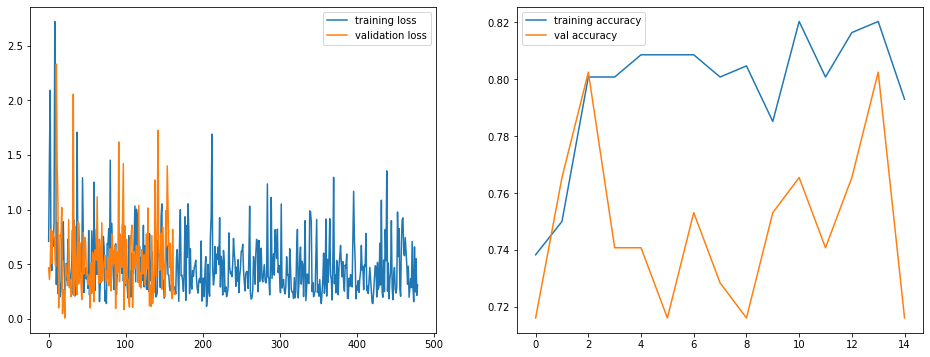

In [ ]:
# Plot the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(losses["train"], label="training loss")
ax1.plot(losses["val"], label="validation loss")
ax1.legend()

ax2.plot(hist["train"],label="training accuracy")
ax2.plot(hist["val"],label="val accuracy")
ax2.legend()

plt.show()

In [ ]:
subset_indices_test = torch.randperm(len(image_datasets['test']))[:int(0.1*len(image_datasets['test']))]

test_data_subset = torch.utils.data.Subset(image_datasets['test'], subset_indices_test)

test_dataloader = torch.utils.data.DataLoader(test_data_subset, batch_size=batch_size, shuffle=True, num_workers=4),

In [ ]:
image_names = [os.path.basename(image_datasets['test'].samples[i][0]) for i in subset_indices_test]

In [ ]:
model.eval()

In [ ]:
for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    for i in range(len(preds)):
        prediction = preds[i].item()
        correct_label = labels[i].item()
        image_name = image_names[i]
        print("Imagen: {}, Predicción: {}, Etiqueta correcta: {}".format(image_name, prediction, correct_label))

In [ ]:
"""
image_names --> llista dels noms de les imatges 
hauriem de agafar de cada name nomes els valors abans de "_"
"""

### Plot the tissue

Per fer-ho, hem d'agafar les funciosn de "0. data visualization" i de la imatge del test que estem classificant i sabem que ho ha fet bé, agafar el id (que son els pirmers numeros del path de la imatge) i buscar aquell id en les carpetes i quan ho trobi, buscar a 0 o 1 (depenent del que ha classificat) i plotejar les grafiques 

mirar com treure el id de cada prediccio en test (com saber quina imatge esta classificant) i un cop tenim el id, passar-ho per les funcions a veure si no peta.